In [1]:
import os

In [3]:
# 读取xyz数据
root = r'C:\Users\81004\Desktop\ptr2\data'
file_name = "2000-cry_300k_out.xyz"
#########
file_path = os.path.join(root,file_name)

In [5]:
ana_frame = 0  # 替换为你想要的帧数

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
# 阿伏伽德罗常数 (单位：mol^-1)
Avogadro_number = 6.022e23
# 元素的相对原子质量 (单位：g/mol)
element_masses = {
    'O': 15.999, 'Si': 28.085, 'Na': 22.990, 'Al': 26.982, 'Zn': 65.38, 
    'F': 18.998, 'Br': 79.904, 'K': 39.098
}
# 读取XYZ文件的函数
def read_xyz(file_path, ana_number):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    num_atoms = int(lines[0].strip())  # 获取原子数
    len_page = num_atoms + 2  # 每一帧的总行数，包括原子数和描述行
    atoms = []
    positions = []
    # 找到最大的xyz
    a,b,c = -1000,-1000,-1000
    # 从指定帧的第3行开始读取元素和坐标
    for line in lines[ana_number * len_page + 2:(ana_number + 1) * len_page]:
        parts = line.split()
        element = parts[0]
        x, y, z = map(float, parts[1:])
        if x>a:
            a = x
        if y>b:
            b = y
        if z>c:
            c = z
        atoms.append(element)
        positions.append([x, y, z])
    box_len = [a+0.1,b+0.1,c+0.1]
    # print(f'Boxsize: {box_len}')
    return np.array(positions), atoms, num_atoms,box_len


In [9]:
# 将XY平面划分为网格并计算每个网格内的真实密度
def compute_density(positions, elements, box_size, num_bins=10):
    # 计算网格边长
    dx = box_size[0] / num_bins
    dy = box_size[1] / num_bins
    dz = box_size[2] / num_bins
    
    # 对每种元素分别计算密度
    total_density = np.zeros((num_bins, num_bins, num_bins))  # 3D密度矩阵

    for i, pos in enumerate(positions):
        element = elements[i]
        # 根据给定的网格边长和位置，确定该原子所在的网格位置
        y_idx = int(pos[0] // dx) % num_bins
        x_idx = int(pos[1] // dy) % num_bins
        z_idx = int(pos[2] // dz) % num_bins

        # 计算该原子的质量（单位：g），并增加到网格密度中
        atom_mass = element_masses[element] / Avogadro_number  # 单个原子的质量（单位：g）
        total_density[x_idx, y_idx, z_idx] += atom_mass

    # 计算每个网格的体积（单位：Å³）
    grid_volume = dx * dy * dz  # 体积：Å³

    # 计算每个网格的真实密度 (单位：g/Å³)
    true_density = total_density / grid_volume

    # 将密度从 g/Å³ 转换为 g/cm³
    true_density = true_density * 1e24  # 1 Å³ = 1e-24 cm³, 因此乘以 1e24

    return true_density, dx, dy, dz

In [11]:
# 绘制每个Z层的密度分布图
def plot_density_distribution(true_density, num_bins=10):
    z_idx_range = num_bins
    fig, axes = plt.subplots(z_idx_range // 2, 2, figsize=(15, 10), sharex=True, sharey=True)

    # 遍历每个z层（从0到num_bins-1）
    for z_idx in range(z_idx_range):
        ax = axes[z_idx // 2, z_idx % 2]
        # 获取每个Z层的X-Y密度图
        density_map = true_density[:, :, z_idx]  # 每个z层的密度分布
        im = ax.imshow(density_map, origin='lower', cmap='viridis', extent=(0, num_bins, 0, num_bins))
        ax.set_title(f'Density - Z Layer {z_idx + 1}')
        ax.set_xlabel('X Bin')
        ax.set_ylabel('Y Bin')
        fig.colorbar(im, ax=ax)  # 为每个子图添加colorbar

    plt.tight_layout()
    plt.show()

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [15]:
# 绘制每个Z层的密度分布图
def plot_density_distribution1(true_density=[], num_bins=10, box_size=100.0):
    # 定义密度范围，这里使用了更高对比度的渐变色，颜色从浅到深
    levels = [1.0, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.5]

    # 使用Inferno渐变色，颜色深浅区分度更高
    cmap = plt.cm.inferno
    norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)

    z_idx_range = num_bins
    fig, axes = plt.subplots(z_idx_range // 2, 2, figsize=(15, 10), sharex=True, sharey=True)

    # 计算每个bin的大小
    bin_size = box_size / num_bins
    x_vals = np.linspace(0, box_size, num_bins)
    y_vals = np.linspace(0, box_size, num_bins)

    # 遍历每个z层（从0到num_bins-1）
    for z_idx in range(z_idx_range):
        ax = axes[z_idx // 2, z_idx % 2]
        
        # 获取每个Z层的X-Y密度图
        density_map = true_density[:, :, z_idx]  # 每个z层的密度分布
        im = ax.imshow(density_map, origin='lower', cmap=cmap, norm=norm, extent=(0, box_size, 0, box_size))
        
        # 计算并设置标题和坐标轴标签
        z_min = z_idx * bin_size  # Z层的起始位置
        z_max = (z_idx + 1) * bin_size  # Z层的结束位置
        ax.set_title(f'Density - Z Layer {z_idx + 1} (Z Range: {z_min:.2f} - {z_max:.2f} Å)')
        ax.set_xlabel('X (Å)')
        ax.set_ylabel('Y (Å)')

        # 设置X和Y坐标刻度为实际的物理坐标值
        ax.set_xticks(x_vals)
        ax.set_yticks(y_vals)
        
        # 添加颜色条
        cbar = fig.colorbar(im, ax=ax, ticks=levels)
        cbar.set_label('Density (g/cm³)', rotation=270, labelpad=15)

    plt.tight_layout()
    plt.show()


In [17]:
boxsize = np.array([81.3982, 81.3982, 81.3982]) 

In [19]:
# 主函数
def analyze_density(xyz_file, ana_frame,boxsize, num_bins=9):
    positions, elements, num_atoms,box_size = read_xyz(xyz_file, ana_frame)
    if boxsize is not None:
        box_size = boxsize
    # 处理周期性边界
    # positions = apply_periodic_boundary(positions, box_size)

    # 计算真实密度
    true_density, dx, dy, dz = compute_density(positions, elements, box_size, num_bins)
    
    # 绘制密度分布
    plot_density_distribution1(true_density, num_bins, box_size[0])

In [53]:
file_name = "4000-cry_300k_out.xyz"
#########
file_path = os.path.join(root,file_name)

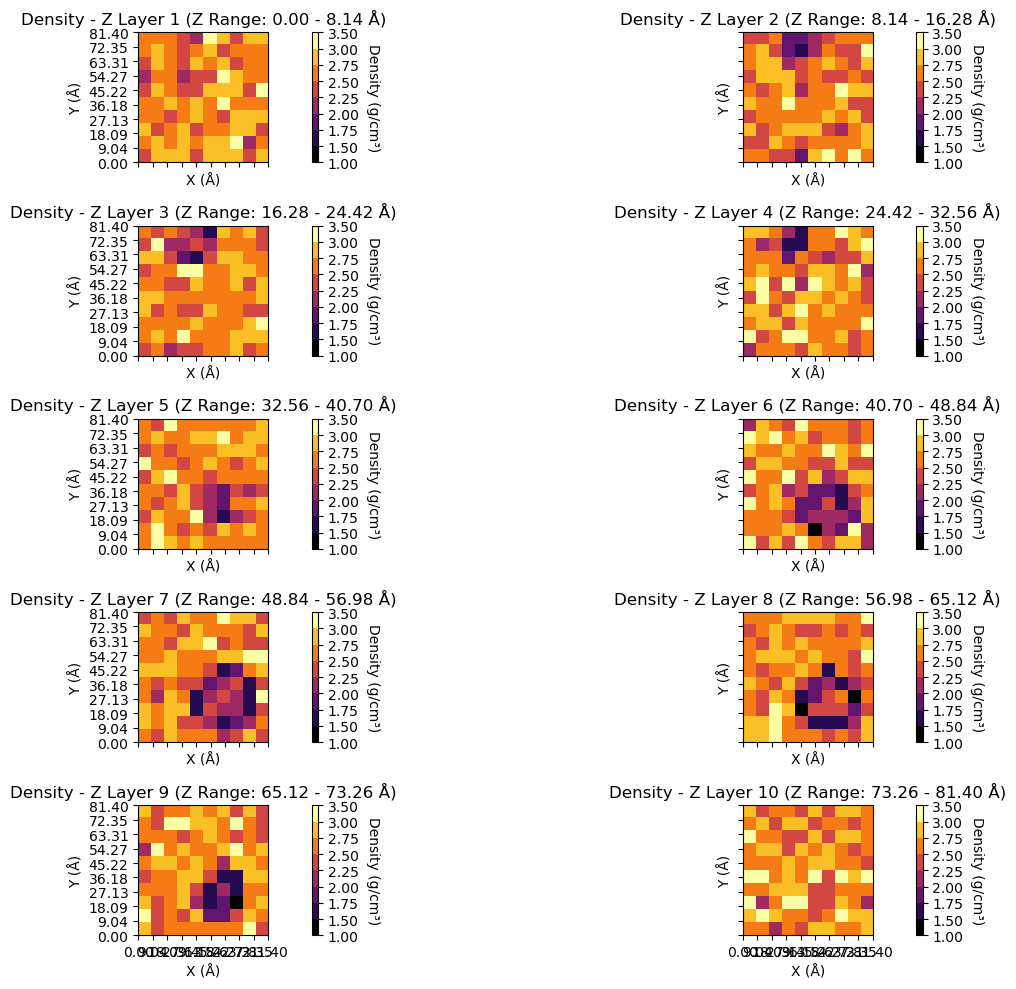

In [55]:
# 设定周期性盒子的尺寸，单位是Å
# 运行主程序，输入xyz文件路径
xyz_file = file_path  # 替换为你的xyz文件路径
# 输入你要分析的帧数（例如第2帧）
ana_frame = 0  # 替换为你想要的帧数
# 运行程序
analyze_density(xyz_file, ana_frame,boxsize,num_bins=10)
